In [1]:
pip install --upgrade plotly

     |████████████████████████████████| 13.0MB 241kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


In [2]:
!nvidia-smi

Tue Sep 15 10:35:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# This program replicates the EDA, FE & Modelling 
- credit (https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling#3.-Melting-the-data)

In [3]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [4]:
# from google.colab import files
# from IPython.display import Image

In [5]:
# uploaded=files.upload()

- credits from (https://towardsdatascience.com/m5-forecasting-accuracy-24d7f42130de)

In [6]:
# Image('DatasetInfo.png', width=1200)

# 1. Dataset:
- 42,840 hierarchical sales data
- includes product items (3049), departments (10), product categories (3), stores (10 stores, from 3 states)
- 5 years of dataset 29th Jan 2011 to 24th April 2016.
- Explanatory variables: price, SNAP events, day of week, special events and festivals
- Hierarchical aggregation captures the combination of these factors to perform bottom up approach. eg- one series for all sales (bottom) or one series for each state.

#2.  Hypothesis
"Sales are affected by some factors whicha are state below"
- **Day:** Customers shopping time and spending mostly depends on the weekend. Many customers may like to shop only at weekends.
- **Special Events/Holidays:** Depending on the events and holidays customers purchasing behavior may change. For holidays like Easter, food sales may go up and for sporting events like Superbowl finals Household item sales may go up.
- **Product Price:** The sales are affected the most by the product price. Most customers will check the price tag before making the final purchase.
- **Product Category:** The type of product greatly affects sales. For instance, products in the household like TV will have fewer sales when compared with sales of food products.
- **Location:** The location also plays an important role in sales. In states like California, the customers might buy products they want irrespective of price, and customers in another region may be price sensitive

- **Population and Median Income:** Population and the mean/median income of individuals also plays a significant role for the product sale. 

State     |   Population (Mill)   | Median Income ($)
------------|-----------|--------------
California | 39.51  | 75,277
Texas      | 29    | 59,570
Wisconsin  | 5.822 | 60,733

- Both the population and family income is highest in California,indicating possibility of highest sales. The population is the lowest in Wisconsin (almost 6-7 folds) indicates lower sales in Winconsin. 



Lets fetch the data,

In [7]:
#Fetch the dataset
path='/content/drive/My Drive/GoogleColab/'
sales = pd.read_csv(path+'sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv(path+'calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv(path+'sell_prices.csv')
prices.name = 'prices'


In [8]:
pd.set_option('display.max_columns', None)  
# pd.set_option('display.max_rows', None)  
sales.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511,d_512,d_513,d_514,d_515,d_516,d_517,d_518,d_519,d_520,d_521,d_522,d_523,d_524,d_525,d_526,d_527,d_528,d_529,d_530,d_531,d_532,d_533,d_534,d_535,d_536,d_537,d_538,d_539,d_540,d_541,d_542,d_543,d_544,d_545,d_546,d_547,d_548,d_549,d_550,d_551,d_552,d_553,d_554,d_555,d_556,d_557,d_558,d_559,d_560,d_561,d_562,d_563,d_564,d_565,d_566,d_567,d_568,d_569,d_570,d_571,d_572,d_573,d_574,d_575,d_576,d_577,d_578,d_579,d_580,d_581,d_582,d_583,d_584,d_585,d_586,d_587,d_588,d_589,d_590,d_591,d_592,d_593,d_594,d_595,d_596,d_597,d_598,d_599,d_600,d_601,d_602,d_603,d_604,d_605,d_606,d_607,d_608,d_609,d_610,d_611,d_612,d_613,d_614,d_615,d_616,d_617,d_618,d_619,d_620,d_621,d_622,d_623,d_624,d_625,d_626,d_627,d_628,d_629,d_630,d_631,d_632,d_633,d_634,d_635,d_636,d_637,d_638,d_639,d_640,d_641,d_642,d_643,d_644,d_645,d_646,d_647,d_648,d_649,d_650,d_651,d_652,d_653,d_654,d_655,d_656,d_657,d_658,d_659,d_660,d_661,d_662,d_663,d_664,d_665,d_666,d_667,d_668,d_669,d_670,d_671,d_672,d_673,d_674,d_675,d_676,d_677,d

In [9]:
sales.shape

(30490, 1947)

# 3. Reduction of dataset
***When we go through the complete dataset 30490 by 1947 for validation and 30490 by 1975 for evaluation (2011-01-29 to 1016-06-19 (including forecasting (evaluation date)), the session of my notebook or the google colab both got crashed. Therefore I have reduced the dataset from 2011-01-29 to 2011-04-27 (d_1 to d_89) for validation; and the evaluation date is considered from 2011-04-28-2011-05-25(d_90-d_117).*** 

In [10]:
#lets reduce the sales date from d_90 to d_1947 (columns are dropped)
sales.drop(sales.iloc[:,95:1947], inplace=True, axis=1)

In [11]:
sales.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
sales.shape

(30490, 95)

**Now the shape is reduced to 30490 by 95**

**- Adding zero sales for forecasting days: d_90 - d_117(Test/evaluation)**

In [13]:
#Add zero sales for the forecasting days d_90-d_117
for d in range(90,118):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [14]:
sales.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
sales.shape

(30490, 123)

# The *calendar*, and *prices* dataset also can reduced accordingly, however these dataframe is going to merge with sales based on some columns, so they will managed automatically, and no need to reduced now.

In [16]:
calendar.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


In [17]:
calendar.tail(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [18]:
calendar.shape

(1969, 14)

# But we are trying to reduced (just for practice)

In [19]:
#calendar rows are dropped indexwise,
calendar.drop(calendar.index[89:1969], inplace=True, axis=0)

In [20]:
calendar.shape

(89, 14)

In [21]:
calendar.tail(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
87,2011-04-26,11113,Tuesday,4,4,2011,d_88,Pesach End,Religious,NaN,NaN,0,0,0
88,2011-04-27,11113,Wednesday,5,4,2011,d_89,NaN,NaN,NaN,NaN,0,0,0


Perfect shape !!

In [22]:
#But, for price dataframe, we cant reduced.
prices.head(2)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


#4. Downcasting 
- dataframes to reduce the amount of storage used by them and also to expidite the operations

- **Numerical Columns:** Depending on your environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.

- Here are the different subtypes you can use:

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255
bool : consumes 1 byte, true or false

- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647

- float64 / int64 / uint64: consumes 8 bytes of memory

- If one of your column has values between 1 and 10 for example, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!

- **Categorical Columns:** Categorical Columns: Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [23]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [24]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [25]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

Below plot shows how much effect downcasting has had on the memory usage of DataFrames. Clearly, we have been able to reduce **sales** & **prices** to less than 1/4th of their actual memory usage. **calendar** is already a very small dataframe (in KB).

In [26]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

# 5. Melting the data:     *df.melt(id_vars=['first','last'])*
- Currently, the data is in three dataframes: **sales**, **prices** & **calendar**. 
- The **sales** dataframe contains daily sales data with days(d_1 - d_117) as columns. The **prices** dataframe contains items' price details and **calendar** contains data about the days d.

- In this case what the melt function is doing is that it is converting the sales dataframe which is in **wide format to a long format**. 

- I have kept the *id variables* as *id*, *item_id*, *dept_id*, *cat_id*, *store_id* and *state_id*. 

- They have in total 30490 unique values when compunded together. Now the total number of days for which we have the data is 117 days. Therefore the melted dataframe will be having 30490x117 i.e. *3567330 rows* 

In [27]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [28]:
df.shape

(3567330, 8)

Perfect !!

# 5.1 Combine the data
- Combine *price data* from **prices** dataframe and *days data* from **calendar** dataset to our original datafram *df*.

In [29]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left')

In [30]:
df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN


***Now we have a single and a complete dataframe with all the data required. Let's Explore!***

# 6. Exploratory Data Analysis

- The dataset distribution:

The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated. The products are sold across ten stores, located in three States (CA, TX, and WI). Only the thing is dataset is now reduced !

In [31]:
 #Distribution of Walmarts items

In [32]:
group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
fig = px.treemap(group, path=['USA', 'State', 'Store', 'Category', 'Department'], values='Count',
                  color='Count',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Walmart: Distribution of items')
fig.update_layout(template='seaborn')
fig.show()

# 6.1 Item Prices
- The item prices and their distribution is presented using *violin* graph. Since the price could vary weekly, average price is considered.

In [33]:
group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores',legend_title_text='State')
fig.show()

Below are some of some **insights** of the plots:-

- The distribution of item prices is almost uniform for all the stores across Califoria, Texas and Wisconsin. However, comparatively, price of Household_2_446 at TX_3 sold in high price (28 dollars).
- The price of HOUSEHOLD is expensive in all the states.


In [34]:
group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores across Categories',
                 legend_title_text='Category')
fig.show()

**As can be seen from the plot above, Hobbies category items are quite cheap as compared with food and household items. Food and Hobbies items have almost the same price range**

# 6.2 Items Sold
Let's study the sales accross all the stores.

In [35]:
group = df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='sold',box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold wrt Stores',legend_title_text='State')
fig.show()

**Below are some of the observations from the above plot:-**

- **In California: CA_3** has sold the most number of items while, CA_4 has sold the least number of items.
- **In Texas: TX_2**  have sold the maximum number of items. while **TX_1** and **TX_3** has sold the equal number of items.
- **Wisconsin: WI_3** has sold the maximum number of items while, sales of **WI_1** consist high variation compared to **WI_3** 

- **In overall CA_3** and **WI_3** have sold the most number of items while, **CA_4** has sold the least number of items.

In [36]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [37]:
groupWk = df.groupby(['weekday','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(groupWk, x='weekday', color='state_id', y='sold',box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold wrt Stores',legend_title_text='State')
fig.show()

Weekdays has the maximum sales in all three states, comparatively higher inCalifornia and WI. 

***Let's study number of items sold over time across all the stores.***

In [38]:
fig = go.Figure()
title = 'Items sold over time'
years = group.year.unique().tolist()
buttons = []
y=3
for state in group.state_id.unique().tolist():
    group_state = group[group['state_id']==state]
    for store in group_state.store_id.unique().tolist():
        group_state_store = group_state[group_state['store_id']==store]
        fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['sold'], showlegend=True, 
                                   yaxis='y'+str(y) if y!=1 else 'y'))
    y-=1

fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-04-27'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                # dict(count=6,
                #      label="6m",
                #      step="month",
                #      stepmode="backward"),
                # dict(count=1,
                #      label="YTD",
                #      step="year",
                #      stepmode="todate"),
                # dict(count=1,
                #      label="1y",
                #      step="year",
                #      stepmode="backward"),
                # dict(count=2,
                #      label="2y",
                #      step="year",
                #      stepmode="backward"),
                # dict(count=3,
                #      label="3y",
                #      step="year",
                #      stepmode="backward"),
                # dict(count=4,
                #      label="4y",
                #      step="year",
                #      stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        autorange=True,
        domain=[0, 0.33],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title='WI',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    # yaxis2=dict(
    #     anchor="x",
    #     autorange=True,
    #     domain=[0.33, 0.66],
    #     mirror=True,
    #     showline=True,
    #     side="left",
    #     tickfont={"size":10},
    #     tickmode="auto",
    #     ticks="",
    #     title = 'TX',
    #     titlefont={"size":20},
    #     type="linear",
    #     zeroline=False
    # ),
    # yaxis3=dict(
    #     anchor="x",
    #     autorange=True,
    #     domain=[0.66, 1],
    #     mirror=True,
    #     showline=True,
    #     side="left",
    #     tickfont={"size":10},
    #     tickmode="auto",
    #     ticks='',
    #     title="CA",
    #     titlefont={"size":20},
    #     type="linear",
    #     zeroline=False
    # )
    )
fig.update_layout(template='seaborn', title=title)
fig.show()

***This graph shows,

 - the weakly seasonality on the items sold 
 - maximum sell in CA_4 while least in CA_1
 

# 6.3 State wise Analysis

- In this section, I will be studying the sales and revenue of all the stores individually across all the three states: *California*, *Texas* & *Wisconsin*.
 - I have plotted total three plots for each store: *CA_1*, *CA_2*, *CA_3*, *CA_4*, *TX_1*, *TX_2*, *TX_3*, *WI_1*, *WI_2* & *WI_3*. 
 
**Details about the plots are as follows:-**

- First plot shows the daily sales of a store (total items sold). I have plotted the values separately for SNAP days. Also, **SNAP promotes food purchase**, *I have plotted food sales as well to check if it really affects the food sales.*

- Second plot shows the **daily revenue** of a store with separate plotting **for SNAP days**.

- Third is a heatmap to show **daily sales**. It's plotted in such a way that it becomes easier *to see day wise values.*

In [39]:
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)

In [40]:
def introduce_nulls(df):
    idx = pd.date_range(df.date.dt.date.min(), df.date.dt.date.max())
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'},inplace=True)
    return df

def plot_metric(df,state,store,metric):
    store_sales = df[(df['state_id']==state)&(df['store_id']==store)&(df['date']<='2011-04-27')]
    food_sales = store_sales[store_sales['cat_id']=='FOODS']
    store_sales = store_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_sales = store_sales[store_sales['snap_'+state]==1]
    non_snap_sales = store_sales[store_sales['snap_'+state]==0]
    food_sales = food_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_foods = food_sales[food_sales['snap_'+state]==1]
    non_snap_foods = food_sales[food_sales['snap_'+state]==0]
    non_snap_sales = introduce_nulls(non_snap_sales)
    snap_sales = introduce_nulls(snap_sales)
    non_snap_foods = introduce_nulls(non_snap_foods)
    snap_foods = introduce_nulls(snap_foods)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=non_snap_sales['date'],y=non_snap_sales[metric],
                           name='Total '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_sales['date'],y=snap_sales[metric],
                           name='Total '+metric+'(SNAP)'))
    fig.add_trace(go.Scatter(x=non_snap_foods['date'],y=non_snap_foods[metric],
                           name='Food '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_foods['date'],y=snap_foods[metric],
                           name='Food '+metric+'(SNAP)'))
    fig.update_yaxes(title_text='Total items sold' if metric=='sold' else 'Total revenue($)')
    fig.update_layout(template='seaborn',title=store)
    fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2011-04-27'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ))
    return fig

In [41]:
cal_data = group.copy()
cal_data = cal_data[cal_data.date <= '27-04-2011']
cal_data['week'] = cal_data.date.dt.weekofyear
cal_data['day_name'] = cal_data.date.dt.day_name()

In [42]:
def calmap(cal_data, state, store, scale):
    cal_data = cal_data[(cal_data['state_id']==state)&(cal_data['store_id']==store)]
    years = cal_data.year.unique().tolist()
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = cal_data[cal_data['year']==year]
        data = introduce_nulls(data)
        fig.add_trace(go.Heatmap(
            z=data.sold,
            x=data.week,
            y=data.day_name,
            hovertext=data.date.dt.date,
            coloraxis = "coloraxis",name=year,
        ),r,1)
        fig.update_yaxes(title_text=year,tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    fig.update_layout(coloraxis = {'colorscale':scale})
    fig.update_layout(template='seaborn', title=store)
    return fig

In [43]:
fig = plot_metric(df,'CA','CA_1','sold')
fig.show()

In [44]:
fig = plot_metric(df,'CA','CA_1','revenue')
fig.show()

In [45]:
#For CA_2
fig = plot_metric(df,'CA','CA_2','sold')
fig.show()

In [46]:
fig = plot_metric(df,'CA','CA_2','revenue')
fig.show()

In [47]:
#CA_3
fig = plot_metric(df,'CA','CA_3','sold')
fig.show()

In [48]:
fig = plot_metric(df,'CA','CA_3','revenue')
fig.show()

In [49]:
#CA_4
fig = plot_metric(df,'CA','CA_4','sold')
fig.show()

In [50]:
fig = plot_metric(df,'CA','CA_4','revenue')
fig.show()

# Texas

-Similar discussion of Texas

In [51]:
fig = plot_metric(df,'TX','TX_1','sold')
fig.show()

In [52]:
fig = plot_metric(df,'TX','TX_1','revenue')
fig.show()

In [53]:
fig = plot_metric(df,'TX','TX_2','sold')
fig.show()

In [54]:

fig = plot_metric(df,'TX','TX_2','revenue')
fig.show()

In [55]:
fig = plot_metric(df,'TX','TX_3','sold')
fig.show()

In [56]:
fig = plot_metric(df,'TX','TX_3','revenue')
fig.show()

In [57]:
fig = calmap(cal_data, 'TX', 'TX_3', 'viridis')
fig.show()

# Wisconsin

In [58]:
fig = plot_metric(df,'WI','WI_1','sold')
fig.show()

In [59]:
fig = plot_metric(df,'WI','WI_1','revenue')
fig.show()

In [60]:
fig = calmap(cal_data, 'WI', 'WI_1', 'twilight')
fig.show()

In [61]:
#Similarly we can go for WI_2 and WI_3

# 7. Feature Engineering,

- The goal of feature engineering is **to provide strong and ideally simple relationships between new input features and the output feature** for the supervised learning algorithm to model.

- Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

- **There is no concept of input and output features in time series.** Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps

- **Label Encoding**, **Introduce Lags**, **Mean Encoding**, **Rolling Window Stats**, **Expanding Windows Stats**, **Trends**, **Save the data**

# 7.1 Label Encoding

- Remove unwanted data to create space in RAM for further processing.
- Label Encode categorical features.(We have already converted categorical variable to category type. So, we can use that code as  LableEncoder)
- Remove date as its features are already present (Time series to Supervised learning).
- we have develop a function how we can covert time series into supervised leanring in *TimeSeriesToSupervisedLearning.ipynb*  


In [62]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [63]:
#1
del group, group_price_cat, group_price_store, group_state, group_state_store, cal_data
gc.collect();

#2
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
#3
df.drop('date',axis=1,inplace=True)



In [64]:
df.shape

(3567330, 22)

In [65]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'revenue'],
      dtype='object')

In [66]:
df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,14370,1437,3,1,0,0,1,0,11101.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN


# 5.2 Introduce lags
- Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. (we have develop a function how we can covert time series into supervised leanring in *TimeSeriesToSupervisedLearning.ipynb*  )

- Introduce lags to the the target variable sold. The maximum lag I have introduced is 36 days. It's purely upto you how many lags you want to introduce.

In [67]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [68]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_6,sold_lag_12,sold_lag_24,sold_lag_36
0,14370,1437,3,1,0,0,1,0,11101.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5.3 Mean Encoding

***From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value. I have calculated mean encodings on the basis of following logical features I could think of:-***

- item
- state
- store
- category
- department
- category & department
- store & item
- category & item
- department & item
- state & store
- state, store and category
- store, category and department (feel free to add more)

In [69]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

# 5.4 Rolling windows statistics
This method calculates the rolling average of the items sold. More features like rolling min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [70]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

# 5.5 Expanding windows statistics

This is simply an advanced version of the rolling window technique. In the case of a rolling window, the size of the window is constant while the window slides as we move forward in time. Hence, we consider only the most recent values and ignore the past values. Here’s a gif that explains how our expanding window function works:

**I'll be calculating expanding avearge of the items sold. More features like expanding min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.**

In [71]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

# 5.6 Trends

I will be creating a selling trend feature, which will be some positive value if the daily items sold are greater than the entire duration average **(d_1 - d_117)** else negative. More trend features can be added but I'll only add this one to keep it simple.

In [72]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

# 5.7 Save the data
- Now since all the *new features are created*, let's save the data so that it can be trained separately.

- Also, lags introduce a lot of Null values, so I'll remove data for first 35 days as I have introduced lags till 36 days.

In [73]:
df = df[df['d']>=36]

In [74]:
#Let's look at our new dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500180 entries, 1067150 to 3567329
Data columns (total 44 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  float64
 9   weekday                   int8   
 10  wday                      float64
 11  month                     float64
 12  year                      float64
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   float64
 18  snap_TX                   float64
 19  snap_WI                   float64
 20  sell_price        

In [75]:
# #Save the data for training.
# df.to_pickle('Finalized_reduced_data.pkl')
# del df
# gc.collect();

# 6. Modelling and Prediction

In [76]:
# data = pd.read_pickle('data.pkl')
# data=df.copy()
# valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
# test = data[data['d']>=1942][['id','d','sold']]
# eval_preds = test['sold']
# valid_preds = valid['sold']
data=df.copy()
valid = data[(data['d']>=62) & (data['d']<90)][['id','d','sold']]
test = data[data['d']>=90][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']


In [77]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<62].drop('sold',axis=1), df[df['d']<62]['sold']
    X_valid, y_valid = df[(df['d']>=62) & (df['d']<90)].drop('sold',axis=1), df[(df['d']>=62) & (df['d']<90)]['sold']
    X_test = df[df['d']>=90].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    #save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 1.47086	training's rmse: 1.21279	valid_1's l2: 0.93526	valid_1's rmse: 0.967088
[40]	training's l2: 1.32388	training's rmse: 1.1506	valid_1's l2: 0.811033	valid_1's rmse: 0.900573
[60]	training's l2: 1.22129	training's rmse: 1.10512	valid_1's l2: 0.743094	valid_1's rmse: 0.862029
[80]	training's l2: 1.1331	training's rmse: 1.06447	valid_1's l2: 0.69669	valid_1's rmse: 0.834679
[100]	training's l2: 1.09536	training's rmse: 1.04659	valid_1's l2: 0.685633	valid_1's rmse: 0.82803
[120]	training's l2: 1.05624	training's rmse: 1.02774	valid_1's l2: 0.674697	valid_1's rmse: 0.821399
[140]	training's l2: 1.01453	training's rmse: 1.00724	valid_1's l2: 0.655458	valid_1's rmse: 0.809603
[160]	training's l2: 0.975261	training's rmse: 0.987553	valid_1's l2: 0.642063	valid_1's rmse: 0.801288
[180]	training's l2: 0.933781	training's rmse: 0.966324	valid_1's l2: 0.619712	valid_1's rms

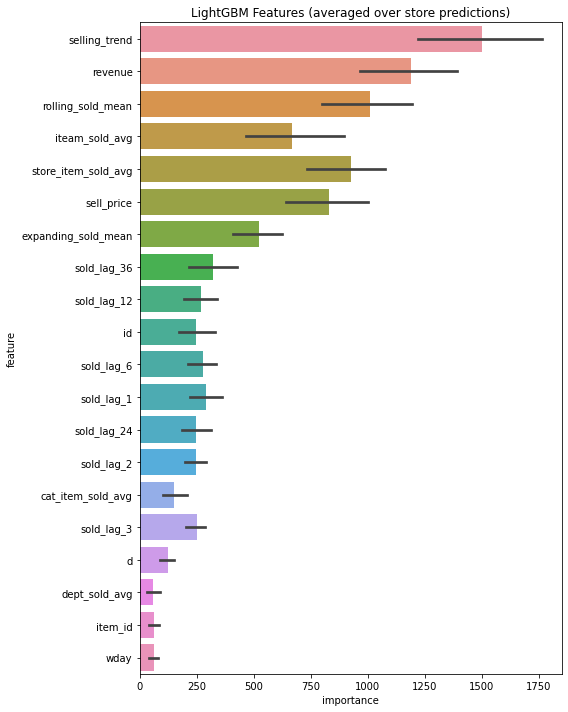

In [78]:
#Plotting feature importances
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('/content/'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# Make the submission
**During feature engineering and training we had melted the provided data from wide format to long format. Now, the predictions are in long format but the format to be evaluated for the competition is in long format. Therefore, I'll convert it into wide format using pivot function in pandas (pivot function). 

In [79]:
valdf=pd.read_csv('/content/drive/My Drive/GoogleColab/sales_train_validation.csv')

In [80]:
valdf.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511,d_512,d_513,d_514,d_515,d_516,d_517,d_518,d_519,d_520,d_521,d_522,d_523,d_524,d_525,d_526,d_527,d_528,d_529,d_530,d_531,d_532,d_533,d_534,d_535,d_536,d_537,d_538,d_539,d_540,d_541,d_542,d_543,d_544,d_545,d_546,d_547,d_548,d_549,d_550,d_551,d_552,d_553,d_554,d_555,d_556,d_557,d_558,d_559,d_560,d_561,d_562,d_563,d_564,d_565,d_566,d_567,d_568,d_569,d_570,d_571,d_572,d_573,d_574,d_575,d_576,d_577,d_578,d_579,d_580,d_581,d_582,d_583,d_584,d_585,d_586,d_587,d_588,d_589,d_590,d_591,d_592,d_593,d_594,d_595,d_596,d_597,d_598,d_599,d_600,d_601,d_602,d_603,d_604,d_605,d_606,d_607,d_608,d_609,d_610,d_611,d_612,d_613,d_614,d_615,d_616,d_617,d_618,d_619,d_620,d_621,d_622,d_623,d_624,d_625,d_626,d_627,d_628,d_629,d_630,d_631,d_632,d_633,d_634,d_635,d_636,d_637,d_638,d_639,d_640,d_641,d_642,d_643,d_644,d_645,d_646,d_647,d_648,d_649,d_650,d_651,d_652,d_653,d_654,d_655,d_656,d_657,d_658,d_659,d_660,d_661,d_662,d_663,d_664,d_665,d_666,d_667,d_668,d_669,d_670,d_671,d_672,d_673,d_674,d_675,d_676,d_677,d

In [81]:
valdf.shape

(30490, 1919)

In [82]:
valdf_reduced=valdf.drop(valdf.iloc[:,67:1919],axis=1)

In [83]:
valdf_reduced.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = False
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(62,90)]]
    #validation['id']=pd.read_csv('/content/drive/My Drive/GoogleColab/sales_train_validation.csv').id
    validation['id']=valdf_reduced
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')



In [85]:
#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)


In [86]:
#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission.csv',index=False)

In [87]:
submit.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_CA_1_validation,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,1.0
4,HOBBIES_1_005_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,HOBBIES_1_006_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,HOBBIES_1_007_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,HOBBIES_1_008_CA_1_validation,0.0,0.0,0.0,20.0,0.0,2.0,13.0,13.0,0.0,0.0,0.0,8.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,5.0,23.0,0.0,0.0,16.0,9.0,10.0,8.0,1.0
8,HOBBIES_1_009_CA_1_validation,4.0,0.0,4.0,0.0,1.0,1.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,4.0,1.0,6.0,1.0,2.0,8.0,0.0,2.0,2.0,0.0,9.0,0.0,0.0,3.0
9,HOBBIES_1_010_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
submit.tail(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60970,HOUSEHOLD_2_516_CA_1_evaluation,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075,-0.000075
60971,HOUSEHOLD_2_516_CA_2_evaluation,0.000036,0.000036,-0.009957,-0.009330,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,-0.009330,-0.009330,0.000036,0.000036,0.000036,0.000036,-0.009330,0.000036,0.000036,-0.009330,0.000036
60972,HOUSEHOLD_2_516_CA_3_evaluation,-0.003156,-0.003156,-0.003156,-0.002121,-0.003156,-0.002121,-0.003156,-0.003156,-0.002121,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156,-0.003156
60973,HOUSEHOLD_2_516_CA_4_evaluation,-0.000214,-0.000214,-0.000203,-0.000214,-0.000214,-0.000214,-0.000203,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.000214,-0.004033,-0.000214,-0.000214,-0.000214,-0.004033,-0.000214
60974,HOUSEHOLD_2_516_TX_1_evaluation,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000063,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000653,0.000063
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.025330,0.025167,0.027854,0.023385,0.023385,0.023385,0.023385,0.023385,0.023385,0.023385,0.027854,0.027854,0.023385,0.023385,0.027854,0.023385,0.023385,0.027854,0.023385,0.023385,0.023385,0.023385,0.023385,0.027854,0.023385,0.027854,0.023385,0.023385
60976,HOUSEHOLD_2_516_TX_3_evaluation,-0.026031,-0.026031,-0.026031,-0.026031,-0.021204,-0.026031,-0.026031,-0.021204,-0.026031,-0.026031,-0.026031,-0.026031,-0.026031,-0.021204,-0.026031,-0.026031,-0.026031,-0.026031,-0.026031,-0.026031,-0.021204,-0.026031,-0.026031,-0.026031,-0.026031,-0.026031,-0.026031,-0.026031
60977,HOUSEHOLD_2_516_WI_1_evaluation,-0.011242,-0.011242,-0.011242,-0.011291,-0.011242,-0.012404,-0.011242,-0.011291,-0.011242,-0.011242,-0.011242,-0.011242,-0.011291,-0.011242,-0.011242,-0.011242,-0.011242,-0.011242,-0.011242,-0.011242,-0.011242,-0.011242,-0.011242,-0.011291,-0.011242,-0.011242,-0.011242,-0.011242
60978,HOUSEHOLD_2_516_WI_2_evaluation,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,0.000160,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037
60979,HOUSEHOLD_2_516_WI_3_evaluation,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.010210,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837,0.008837
